# Figure 4.

Eddy geopotential height (shading, $m$) and eddy components of horizontal wind vectors 250 $hPa$ and air temperature (contours, $K$) at 700 $hPa$ in the (left column) Trappist-1e case and (right column) Proxima b case in (a, b) *MassFlux*, (c, d) *Adjust*, and (e, f) *NoCnvPm* simulations. Here the eddy component is taken as the deviation from the temporal and zonal mean.

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

Import the necessary libraries.

In [1]:
import warnings

warnings.filterwarnings("ignore")

Scientific stack

In [2]:
import iris

import matplotlib.pyplot as plt
import matplotlib.patheffects as PE

import numpy as np

In [3]:
from aeolus.calc import last_year_mean, zonal_mean
from aeolus.coord_utils import UM_TIME
from aeolus.core import Run

In [4]:
from commons import (
    GLM_MODEL_TIMESTEP,
    PLANET_ALIASES,
    RUN_ALIASES,
    OUTPUT_NAME_PREFIX,
)
from gl_diag import calc_derived_cubes, interp_to_pressure_levels
import mypaths
from plot_func import (
    CART_KW,
    MARKER_KW,
    add_aux_yticks,
    add_custom_legend,
    draw_scalar_cube,
    draw_vector_cubes,
    make_map_figure,
    use_style,
)

Global stylesheet for figures.

In [5]:
use_style()

## Load data

Create a dictionary of `Run` objects with preprocessed data.

In [6]:
runs = {}
for planet in PLANET_ALIASES.keys():
    for run_key in RUN_ALIASES.keys():
        label = f"{planet}_{run_key}"

        fname = mypaths.sadir / label / "_processed" / f"{label}.nc"

        runs[label] = Run(
            files=fname,
            name=label,
            planet=planet,
            timestep=GLM_MODEL_TIMESTEP,
            processed=True,
        )
        runs[label].add_data(calc_derived_cubes)

## Additional local functions

Define functions to calculate eddy components

In [7]:
def zonal_and_time_mean_eddy_cmpnts(cube):
    """Get the zonal and temporal mean and eddy components of a cube."""
    mean = zonal_mean(cube).collapsed(UM_TIME, iris.analysis.MEAN)
    eddy = (cube - mean).collapsed(UM_TIME, iris.analysis.MEAN)
    for i in [mean, eddy]:
        i.attributes.update({k: v for k, v in cube.attributes.items() if k != "STASH"})
    return mean, eddy

In [8]:
def _g_hgt_eddy_mean(cubelist, level):
    """Get the mean eddy component of geopotential height."""
    g_hgt_plev = interp_to_pressure_levels(cubelist, "geopotential_height", level)

    g_hgt_plev_mean, g_hgt_plev_eddy = zonal_and_time_mean_eddy_cmpnts(g_hgt_plev)

    g_hgt_eddy_mean_slice = g_hgt_plev_eddy.extract(iris.Constraint(air_pressure=level))
    g_hgt_eddy_mean_slice /= g_hgt_eddy_mean_slice.attributes["planet_conf"].gravity.asc
    return g_hgt_eddy_mean_slice

## Plot the results

Pressure level of the geopotential height.

In [9]:
P_LEVEL = 250 * 1e2  # Pa

Pressure level of the temperature field.

In [10]:
P_LEVEL_TEMP = 700 * 1e2  # Pa

Plot settings

In [11]:
# Axes grid specs
AXGR_KW = dict(
    axes_pad=(0.5, 0.4),
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.3,
    cbar_size="1.5%",
    label_mode="",
)

# Arrow specs
quiver_kw = dict(
    scale_units="inches",
    scale=125,
    facecolors=("#444444"),
    edgecolors=("#EEEEEE"),
    linewidths=0.3,
    width=0.004,
    headaxislength=4,
)

Colormap for the surface temperature differences

In [12]:
fig, axgr = make_map_figure(2, 3, **AXGR_KW)

cax = axgr.cbar_axes[0]
for i, (planet, ax_col) in enumerate(zip(PLANET_ALIASES, axgr.axes_column)):
    for run_key, ax in zip(RUN_ALIASES.keys(), ax_col):
        if i == 0 and run_key == "grcs":
            qk_ref_wspd = 30
        else:
            qk_ref_wspd = None
        label = f"{planet}_{run_key}"
        ax.set_title(RUN_ALIASES[run_key], fontsize="medium", pad=5, loc="right")
        if run_key == "grcs":
            ax.set_title(PLANET_ALIASES[planet], fontsize="large", pad=5, loc="center")

        g_hgt_eddy_mean_slice = _g_hgt_eddy_mean(runs[label].proc, [P_LEVEL])

        u = interp_to_pressure_levels(runs[label].proc, "x_wind", [P_LEVEL])
        v = interp_to_pressure_levels(runs[label].proc, "y_wind", [P_LEVEL])
        _, u_eddy = zonal_and_time_mean_eddy_cmpnts(u)
        _, v_eddy = zonal_and_time_mean_eddy_cmpnts(v)

        temp = interp_to_pressure_levels(
            runs[label].proc, "air_temperature", [P_LEVEL_TEMP]
        )
        temp = last_year_mean(temp)
        draw_scalar_cube(
            g_hgt_eddy_mean_slice,
            ax,
            method="contourf",
            cax=cax,
            tex_units="$m$",
            cmap="RdBu_r",
            levels=np.arange(-200, 201, 50),
            extend="both",
        )

        cntr = draw_scalar_cube(
            temp,
            ax,
            method="contour",
            cmap="plasma",
            use_cyclic=False,
            levels=np.arange(225, 280, 5),
        )
        clbls = ax.clabel(cntr, fmt="%.0f K", use_clabeltext=True)
        plt.setp(
            cntr.collections, path_effects=[PE.withStroke(linewidth=2, foreground="w")]
        )
        plt.setp(clbls, path_effects=[PE.withStroke(linewidth=2, foreground="w")])

        draw_vector_cubes(
            u_eddy,
            v_eddy,
            ax,
            xstride=8,
            ystride=6,
            qk_ref_wspd=qk_ref_wspd,
            **quiver_kw,
            **CART_KW,
        )
plt.close()  # Show the figure in a separate cell

## Show the figure

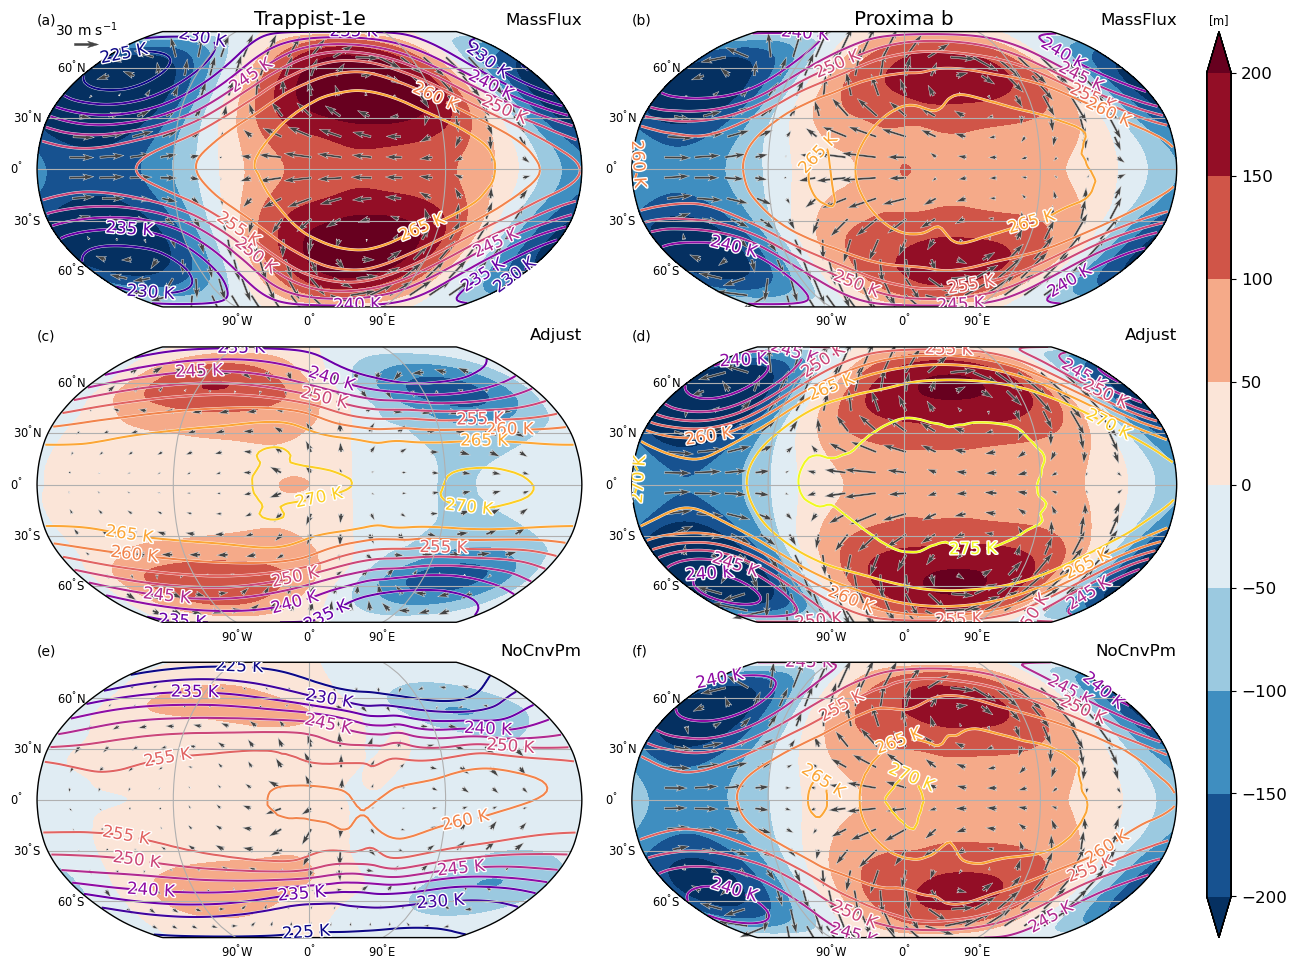

In [13]:
fig

And save it.

In [14]:
imgname = (
    mypaths.plotdir
    / f"{OUTPUT_NAME_PREFIX}__ghgt_winds_eddy__{P_LEVEL/100:.0f}hpa__temp__{P_LEVEL_TEMP/100:.0f}hpa"
)

In [15]:
fig.savefig(imgname, dpi=200)
print(f"Saved to ../{imgname.relative_to(mypaths.topdir)}")

Saved to ../plots/trap1e_proxb__grcs_llcs_all_rain_acoff__ghgt_winds_eddy__250hpa__temp__700hpa
